# Taxi Routes

### Project Description: Create a program that can find the fastest route for a taxi within a city while considering speed and distance. The goal of the project is to mimic Google Maps and visualize how routes are created when there are many factors to account for.

## Gathering Map Data
Road data can be downloaded with [openstreetmap.org](https://www.openstreetmap.org) after specifying longitute/latitude bounds and exporting with the Overpass API option.

In [68]:
import xml.etree.ElementTree as ET
tree = ET.parse('rioSalado')
root = tree.getroot()

# get bounds
boundsData = root.find('bounds').attrib
minX = float(boundsData['minlat'])
minY = float(boundsData['minlon'])
maxX = float(boundsData['maxlat'])
maxY = float(boundsData['maxlon'])

print("Latitude bounds\nlower: %f, upper:%f" % (minX, maxX))
print("Longitude bounds\nlower: %f, upper:%f" % (minY, maxY))

Latitude bounds
lower: 33.429210, upper:33.431670
Longitude bounds
lower: -111.940960, upper:-111.937600


### Another approach is to download a shapefile(.shp) of the area on [geofabrik.de](https://download.geofabrik.de/north-america/us.html). This is the map plotted out with the shapefile.

    osm_id  code        fclass                   name   ref oneway  maxspeed  \
0  5561436  5141       service                   None  None      B         0   
1  5565693  5133  primary_link                   None  None      F         0   
2  5584300  5141       service                   None  None      B         0   
3  5584509  5141       service                   None  None      B         0   
4  5587308  5122   residential  North Camellia Street  None      B        40   

   layer bridge tunnel                                           geometry  
0      0      F      F  LINESTRING (-111.95182 33.44411, -111.95185 33...  
1      0      F      F  LINESTRING (-111.94859 33.44458, -111.94873 33...  
2      0      F      F  LINESTRING (-111.95586 33.44872, -111.95577 33...  
3      0      F      F  LINESTRING (-111.95269 33.44945, -111.95224 33...  
4      0      F      F  LINESTRING (-111.92134 33.44801, -111.92135 33...  


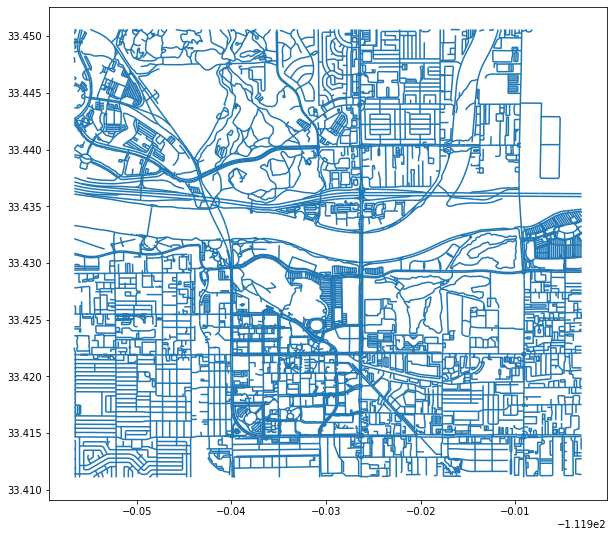

In [2]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt

metroMap = gpd.read_file('shp/tempeRoads.shp')
metroMap.plot(figsize=(10,10))
print(metroMap.head())

plt.show()

### Using the XML formatted data from Overpass API, the nodes and their corresponding coordinates can be plotted with geopandas. The XML formatted file is more detailed than the shapefile.

<AxesSubplot:>

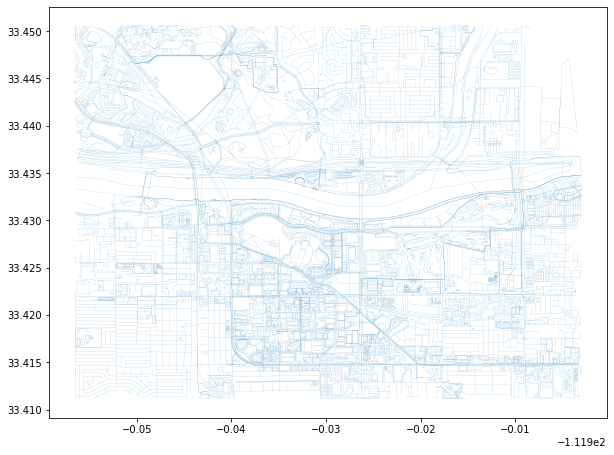

In [31]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

tree = ET.parse('map.xml')
root = tree.getroot()
nodes = dict()

# hash all nodes
for item in root.findall('node'):
    id = item.attrib.pop('id', None)
    nodes[id] = item.attrib

series = []

# draw all ways
for item in root.findall('way'):
    points = []
    for child in item.findall('nd'):
        node = nodes[child.attrib['ref']]
        lat = float(node['lat'])
        lon = float(node['lon'])

        # ensure that the nodes are within the area specified
        if lat >= minX and lat <= maxX and lon >= minY and lon <= maxY:
            # create a tuple of LONGTITUDE and LATITUDE for accurate map
            points.append((lon, lat))
    
    if len(points) >= 2:
        lineString = LineString(points)
        series.append(lineString)

tempeDataFrame = gpd.GeoDataFrame(geometry=series)
tempeDataFrame.plot(figsize=(10,10), linewidth=0.1)

### Extract and plot all road-related data

<AxesSubplot:>

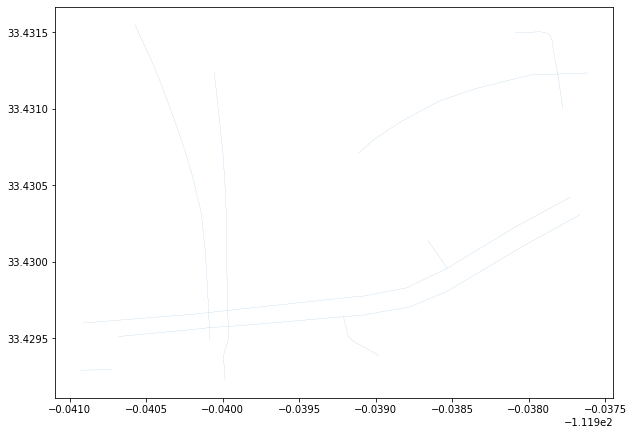

In [126]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

tree = ET.parse('rioSalado')
root = tree.getroot()

graph = dict()
nodes = dict()
tagValues = set()

# hash all nodes
for item in root.findall('node'):
    id = item.attrib.pop('id', None)
    nodes[id] = item.attrib

    key = (float(nodes[id]['lon']), float(nodes[id]['lat']))
    values = graph.get(key, None)
    #print(key)

    if values == None:
        graph[key] = []

series = []

# draw all ways
for item in root.findall('way'):
    # check that the way is a car friendly
    filters = ['footway', 'path', 'cycleway', 'pedestrian', 'steps', 'track', 'dismantled']

    keys = ['maxspeed', 'highway', 'lanes', 'service']

    roadType = False
    for tag in item.findall('tag'):
        if tag.attrib['k'] in keys and tag.attrib['v'] not in filters:
            roadType = True
            tagValues.add(tag.attrib['v'])
    
    if roadType == False:
        continue

    points = []
    for child in item.findall('nd'):
        node = nodes[child.attrib['ref']]
        lat = float(node['lat'])
        lon = float(node['lon'])

        # ensure that the nodes are within the area specified
        if lat >= minX and lat <= maxX and lon >= minY and lon <= maxY:
            # create a tuple of LONGTITUDE and LATITUDE for accurate map
            points.append((lon, lat))

    if len(points) >= 2:
        lineString = LineString(points)
        series.append(lineString)

        for i in range(len(points) - 1):
            if points[i] not in graph or points[i + 1] not in graph:
                continue
            values = graph.get(points[i])
            if points[i + 1] not in values:
                values.append(points[i + 1])
                graph[key] = values

tempeDataFrame = gpd.GeoDataFrame(geometry=series)
tempeDataFrame.plot(figsize=(10,10), linewidth=0.1)

#print(tagValues)
#print(graph)

### Perform BFS starting from an arbitrary coordinate

[(-111.9400872, 33.4295692), (-111.9400836, 33.4294932), (-111.9400264, 33.4295732)]
[(-111.9400948, 33.4297326), (-111.9400919, 33.4296678)]
[(-111.9380508, 33.4300944), (-111.9376678, 33.4303063)]
[(-111.9390802, 33.4296518), (-111.9387779, 33.4297044)]
[(-111.9399972, 33.4306963), (-111.9400262, 33.4309705)]
[(-111.9399734, 33.4300281), (-111.9399748, 33.4301976)]
[(-111.9401986, 33.4305606), (-111.9401399, 33.4303209)]
[(-111.940306, 33.4308981), (-111.9402509, 33.4307385)]
[(-111.9404627, 33.431309), (-111.940398, 33.4311519)]
[(-111.940113, 33.4300629), (-111.9400948, 33.4297326)]
[(-111.9385345, 33.4298061), (-111.9381867, 33.4300134)]
[(-111.9387779, 33.4297044), (-111.9385345, 33.4298061)]
[(-111.9402509, 33.4307385), (-111.9401986, 33.4305606)]
[(-111.9398814, 33.4295827), (-111.9392114, 33.4296405)]
[(-111.940398, 33.4311519), (-111.940306, 33.4308981)]
[(-111.9399635, 33.4295773), (-111.9399677, 33.4296814), (-111.9398814, 33.4295827)]
[(-111.9399703, 33.4297456), (-111.939

<AxesSubplot:>

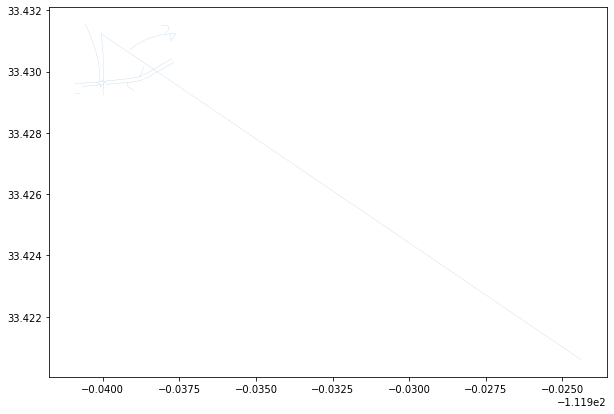

In [134]:
import networkx as nx
from matplotlib import pylab

pointSeries = []

for key in graph:
    if len(graph.get(key, [])) != 0:
        points = []
        points.append(key)
        for elem in graph[key]:
            points.append(elem)
        print(points)
        pointSeries.append(LineString(points))

edgesDataFrame = gpd.GeoDataFrame(geometry=pointSeries)
edgesDataFrame.plot(figsize=(10,10), linewidth=0.1)

## Tools
 - OpenStreetMap
 - Geopandas
 - Matplotlib